✅ MLflow configured. Tracking to experiment: 'st126488-a3' on the remote server.
--- Class Distribution Check ---
Number of samples in each class after using pd.qcut:
selling_price
0    1991
1    1927
2    1949
3    1947
Name: count, dtype: int64


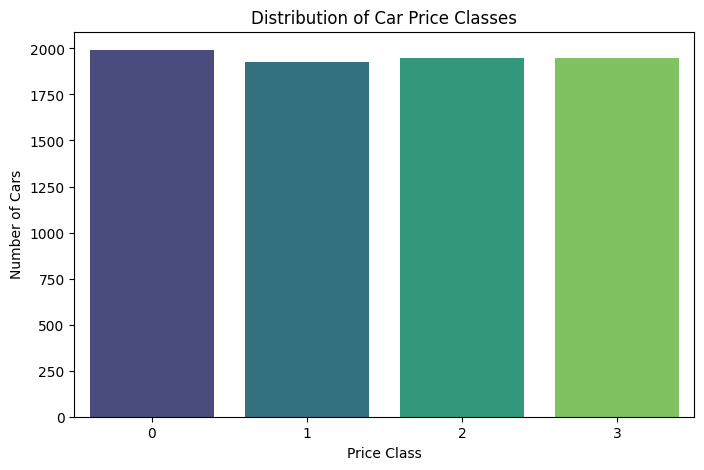


🚀 Starting Comprehensive Hyperparameter Tuning...

--- CV for lr=0.01, gd_type=batch (lambda=0.1) ---
  => Average CV Accuracy over 5 folds: 0.5527 (+/- 0.0151)
🎉 New best CV accuracy found: 0.5527
🏃 View run gd_batch_lr_0.01_lambda_0.1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/974791038746408189/runs/36fde4ecd86848b2b1fbfa0ce33f308d
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/974791038746408189

--- CV for lr=0.001, gd_type=batch (lambda=0.1) ---
  => Average CV Accuracy over 5 folds: 0.5010 (+/- 0.0093)
🏃 View run gd_batch_lr_0.001_lambda_0.1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/974791038746408189/runs/18b8626250844a779dcca11692c3147f
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/974791038746408189

--- CV for lr=0.0001, gd_type=batch (lambda=0.1) ---
  => Average CV Accuracy over 5 folds: 0.4601 (+/- 0.0290)
🏃 View run gd_batch_lr_0.0001_lambda_0.1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiment

2025/10/02 20:52:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Deployment assets (assets.json) logged to MLflow.

Logging and registering the model as 'st126488-a3-model'...


Registered model 'st126488-a3-model' already exists. Creating a new version of this model...
2025/10/02 20:52:15 WARNING mlflow.tracking._model_registry.fluent: Run with id 6ad5b2ec399940088b62c4fce831ac25 has no artifacts at artifact path 'model', registering model based on models:/m-634000c5b304457ca5a50cedfd8a9c73 instead
2025/10/02 20:52:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: st126488-a3-model, version 14
Created version '14' of model 'st126488-a3-model'.


Waiting 5 seconds for the model registry to update...
Setting alias 'Staging' for new version 14...
✅ Successfully set alias 'Staging' for version 14 of model 'st126488-a3-model'.
🏃 View run final_model_best_params at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/974791038746408189/runs/6ad5b2ec399940088b62c4fce831ac25
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/974791038746408189

--- Saving artifacts locally for backup and testing ---
✅ Final model pipeline saved locally to: deploy_assets\best_classifier_pipeline.joblib
✅ Deployment assets saved locally to: deploy_assets\assets.json

       🔬 Inference Testing on Sample Data

--- Testing: Budget Car ---
Input Features:
 car_age  km_driven  mileage  owner  brand  km_per_year
      14     150000     18.0      3 Maruti      10000.0

Prediction:
  -> Predicted Category: Class 0

--- Testing: Mid-Range Car ---
Input Features:
 car_age  km_driven  mileage  owner brand  km_per_year
       6      60000     22

In [ ]:
# A3 - Predicting Car Prices (Classification with CV and MLflow) - IMPROVED
# Name: Alston Alvares      Student ID: st126488

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import mlflow
import warnings
from datetime import datetime
from mlflow.exceptions import MlflowException


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import the custom Logistic Regression model
from custom_classifier import LogisticRegression

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# --- FIX: Add MLflow Server Authentication ---
# IMPORTANT: Replace 'YOUR_USERNAME' and 'YOUR_PASSWORD' with your actual credentials
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'


# --- MLflow Setup ---
# Objective 1: Change the tracking_uri to the remote server
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/") 

# Objective 1: Set the experiment name as per the requirement
experiment_name = "st126488-a3"
mlflow.set_experiment(experiment_name)
print(f"✅ MLflow configured. Tracking to experiment: '{experiment_name}' on the remote server.")


# --- Custom Classification Metrics (remains the same) ---
def custom_classification_report(y_true, y_pred, class_names):
    # This function remains unchanged...
    cm = confusion_matrix(y_true, y_pred)
    n_classes = len(class_names)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    precisions, recalls, f1_scores, supports = [], [], [], []
    for i in range(n_classes):
        TP = cm[i, i]; FP = np.sum(cm[:, i]) - TP; FN = np.sum(cm[i, :]) - TP
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        support = np.sum(cm[i, :])
        precisions.append(precision); recalls.append(recall); f1_scores.append(f1); supports.append(support)
    macro_precision = np.mean(precisions); macro_recall = np.mean(recalls); macro_f1 = np.mean(f1_scores)
    weighted_precision = np.sum(np.array(precisions) * np.array(supports)) / np.sum(supports)
    weighted_recall = np.sum(np.array(recalls) * np.array(supports)) / np.sum(supports)
    weighted_f1 = np.sum(np.array(f1_scores) * np.array(supports)) / np.sum(supports)
    print("="*55); print("         Custom Classification Report (from Scratch)"); print("="*55); print(f"{'':<12}{'precision':<12}{'recall':<12}{'f1-score':<12}{'support'}"); print("-"*55)
    for i in range(n_classes): print(f"{class_names[i]:<12}{precisions[i]:<12.2f}{recalls[i]:<12.2f}{f1_scores[i]:<12.2f}{supports[i]}")
    print("-"*55); print(f"accuracy {accuracy:.2f}"); print(f"\nmacro avg     {macro_precision:<12.2f}{macro_recall:<12.2f}{macro_f1:<12.2f}"); print(f"weighted avg  {weighted_precision:<12.2f}{weighted_recall:<12.2f}{weighted_f1:<12.2f}"); print("="*55)


# --- Data Loading & Preprocessing ---
DATA_PATH = "Cars.csv"
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.lower()
owner_map = {'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4, 'Test Drive Car': 5}
df['owner'] = df['owner'].astype(str).str.strip().replace(owner_map)
df = df[~df['fuel'].isin(['CNG', 'LPG']) & (df['owner'] != 5)]
df['mileage'] = pd.to_numeric(df['mileage'].astype(str).str.extract(r'([\d\.]+)')[0], errors='coerce')
df['brand'] = df['name'].astype(str).str.split().str[0]

# --- FEATURE ENGINEERING ---
current_year = datetime.now().year
df['car_age'] = current_year - df['year']
df['km_per_year'] = df['km_driven'] / (df['car_age'] + 1)


# Define feature set with the new 'km_per_year' feature
X = df[['car_age', 'km_driven', 'mileage', 'owner', 'brand', 'km_per_year']]
y_continuous = df['selling_price']

df_model = pd.concat([X, y_continuous], axis=1).dropna()
X = df_model.drop(columns=['selling_price']).reset_index(drop=True)
y_continuous = df_model['selling_price'].reset_index(drop=True)
y, bin_edges = pd.qcut(y_continuous, q=4, retbins=True, labels=False)

# --- Class Imbalance Check ---
print("--- Class Distribution Check ---")
print("Number of samples in each class after using pd.qcut:")
print(y.value_counts().sort_index())
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette='viridis')
plt.title('Distribution of Car Price Classes')
plt.xlabel('Price Class')
plt.ylabel('Number of Cars')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- Feature Preprocessing Definition ---
poly_features = ['car_age', 'km_driven', 'mileage']
other_num_features = ['owner', 'km_per_year']
cat_cols = ['brand']

preprocessor = ColumnTransformer(
    transformers=[
        ('poly', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False))
        ]), poly_features),
        ('num', SimpleImputer(strategy='median'), other_num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])


# --- Hyperparameter Tuning with Cross-Validation and MLflow ---
print("\n🚀 Starting Comprehensive Hyperparameter Tuning...")
start_time = time.time()

# --- Hyperparameters Search Space ---
learning_rates = [0.01, 0.001, 0.0001]
gd_types = ['batch', 'mini', 'stochastic'] # Test all gradient descent types
fixed_lambda = 0.1 
num_iterations = 30000 

best_cv_accuracy = -1
best_params = {}
all_results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- UPDATE: Add a loop to test all gradient descent types ---
for gd_type in gd_types:
    for lr in learning_rates:
        with mlflow.start_run(run_name=f"gd_{gd_type}_lr_{lr}_lambda_{fixed_lambda}") as run:
            mlflow.log_params({"learning_rate": lr, "lambda": fixed_lambda, "num_iterations": num_iterations, "gd_type": gd_type})
            fold_accuracies = []
            print(f"\n--- CV for lr={lr}, gd_type={gd_type} (lambda={fixed_lambda}) ---")
            
            for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                X_train_fold_processed = full_pipeline.fit_transform(X_train_fold)
                X_val_fold_processed = full_pipeline.transform(X_val_fold)
                
                model = LogisticRegression(lr=lr, num_iter=num_iterations, reg_type='l2', lambda_=fixed_lambda, gd_type=gd_type)
                model.fit(X_train_fold_processed, y_train_fold.to_numpy())
                
                y_val_pred = model.predict(X_val_fold_processed)
                accuracy = accuracy_score(y_val_fold, y_val_pred)
                fold_accuracies.append(accuracy)
            
            mean_cv_accuracy = np.mean(fold_accuracies)
            std_cv_accuracy = np.std(fold_accuracies)
            print(f"  => Average CV Accuracy over 5 folds: {mean_cv_accuracy:.4f} (+/- {std_cv_accuracy:.4f})")
            mlflow.log_metrics({"mean_cv_accuracy": mean_cv_accuracy, "std_cv_accuracy": std_cv_accuracy})
            all_results.append({'lr': lr, 'gd_type': gd_type, 'mean_cv_accuracy': mean_cv_accuracy})
            
            if mean_cv_accuracy > best_cv_accuracy:
                best_cv_accuracy = mean_cv_accuracy
                best_params = {'lr': lr, 'gd_type': gd_type} # Store the best combination
                print(f"🎉 New best CV accuracy found: {best_cv_accuracy:.4f}")
                mlflow.set_tag("best_run", "True")

end_time = time.time()
print("\n" + "="*55); print("        Hyperparameter Tuning Complete!"); print(f"Total time taken: {(end_time - start_time) / 60:.2f} minutes"); print("="*55)
results_df = pd.DataFrame(all_results)
print("\nTuning Results Summary:"); print(results_df.sort_values(by='mean_cv_accuracy', ascending=False))
print(f"\n🏆 Best CV Parameters: {best_params}")
print(f"🏆 Best Mean CV Accuracy: {best_cv_accuracy:.4f}")


# --- Final Model Training, Logging, and Registration (Objective 2) ---
print("\n--- Training Final Model and Registering with MLflow ---")

with mlflow.start_run(run_name=f"final_model_best_params") as run:
    final_params = {**best_params, "lambda": fixed_lambda}
    print("Logging best parameters...")
    mlflow.log_params(final_params)
    
    final_model_pipeline = Pipeline([
        ('preprocessing', full_pipeline),
        ('classifier', LogisticRegression(
            lr=best_params['lr'], 
            num_iter=num_iterations,
            reg_type='l2', 
            lambda_=fixed_lambda, 
            gd_type=best_params['gd_type'], # Use the best gd_type found
            verbose=True 
        ))
    ])
    
    print("Training final model on full training data...")
    final_model_pipeline.fit(X_train, y_train)
    
    print("\n--- Logging Model Training Trace to MLflow ---")
    final_classifier = final_model_pipeline.named_steps['classifier']
    for i, loss in enumerate(final_classifier.loss_history):
        mlflow.log_metric("training_loss", loss, step=i*100)
    
    print("\nEvaluating final model on the test set...")
    y_pred_final = final_model_pipeline.predict(X_test)
    final_accuracy = accuracy_score(y_test, y_pred_final)
    mlflow.log_metric("final_test_accuracy", final_accuracy)
    
    print(f"\nFinal Model Test Accuracy: {final_accuracy:.4f}")
    custom_classification_report(y_test, y_pred_final, [f'Class {i}' for i in range(y.nunique())])
    
    num_cols = poly_features + other_num_features
    assets = {"num_cols": num_cols, "cat_cols": cat_cols, "class_names": [f'Class {i}' for i in range(y.nunique())], "price_bin_edges": list(bin_edges)}
    with open("assets.json", "w") as f:
        json.dump(assets, f, indent=4)
    mlflow.log_artifact("assets.json", artifact_path="model_assets")
    print("\n✅ Deployment assets (assets.json) logged to MLflow.")

    # --- Objective 2: Register the model and set alias ---
    model_name = "st126488-a3-model"
    print(f"\nLogging and registering the model as '{model_name}'...")
    
    mlflow.sklearn.log_model(
        sk_model=final_model_pipeline,
        artifact_path="model",
        input_example=X_train.head() 
    )
    
    run_id = run.info.run_id
    model_uri = f"runs:/{run_id}/model"
    
    registered_model_info = mlflow.register_model(
        model_uri=model_uri,
        name=model_name
    )
    new_version = registered_model_info.version
    
    print("Waiting 5 seconds for the model registry to update...")
    time.sleep(5)
    
    try:
        alias = "Staging"
        print(f"Setting alias '{alias}' for new version {new_version}...")
        client = mlflow.tracking.MlflowClient()
        client.set_registered_model_alias(
            name=model_name,
            alias=alias,
            version=new_version
        )
        print(f"✅ Successfully set alias '{alias}' for version {new_version} of model '{model_name}'.")

    except MlflowException as e:
        print(f"🚨 WARNING: Model registration was successful, but setting the alias failed.")
        print(f"   Please manually set the 'Staging' alias for version {new_version} of '{model_name}' in the MLflow UI.")
        print(f"   Error details: {e}")

# --- Local Saving and Inference Testing ---
print("\n--- Saving artifacts locally for backup and testing ---")
DEPLOY_DIR = "deploy_assets"
os.makedirs(DEPLOY_DIR, exist_ok=True)
model_path = os.path.join(DEPLOY_DIR, "best_classifier_pipeline.joblib")
joblib.dump(final_model_pipeline, model_path)
print(f"✅ Final model pipeline saved locally to: {model_path}")
assets_path = os.path.join(DEPLOY_DIR, "assets.json")
with open(assets_path, "w") as f:
    json.dump(assets, f, indent=4)
print(f"✅ Deployment assets saved locally to: {assets_path}")

print("\n" + "="*55)
print("       🔬 Inference Testing on Sample Data")
print("="*55)

loaded_model = joblib.load(model_path)
test_cases = {
    "Budget Car": {'car_age': 14, 'km_driven': 150000, 'mileage': 18.0, 'owner': 3, 'brand': 'Maruti', 'km_per_year': 150000 / (14 + 1)},
    "Mid-Range Car": {'car_age': 6, 'km_driven': 60000, 'mileage': 22.0, 'owner': 2, 'brand': 'Honda', 'km_per_year': 60000 / (6 + 1)},
    "Premium Car": {'car_age': 2, 'km_driven': 20000, 'mileage': 15.0, 'owner': 1, 'brand': 'BMW', 'km_per_year': 20000 / (2 + 1)}
}

for name, data in test_cases.items():
    input_df = pd.DataFrame([data])
    predicted_class_index = loaded_model.predict(input_df)[0]
    assets = {"num_cols": num_cols, "cat_cols": cat_cols, "class_names": [f'Class {i}' for i in range(y.nunique())], "price_bin_edges": list(bin_edges)}
    predicted_class_name = assets['class_names'][predicted_class_index]
    print(f"\n--- Testing: {name} ---")
    print("Input Features:")
    print(input_df.to_string(index=False))
    print("\nPrediction:")
    print(f"  -> Predicted Category: {predicted_class_name}")

